In [ ]:
import pandas as pd
import ta
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from binance.client import Client
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
from IPython.display import display

# =====  DATA LOADING =====
def get_price_data(symbol='BTCUSDT', days=365):
    """Fetch price data with caching and validation"""
    cache_file = 'price_data.csv'
    try:
        if os.path.exists(cache_file):
            df = pd.read_csv(cache_file)
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df = df.dropna(subset=['Date'])
            return df
        
        print(f"Downloading {days} days of {symbol} data...")
        client = Client()
        klines = client.get_historical_klines(
            symbol=symbol,
            interval=Client.KLINE_INTERVAL_1DAY,
            limit=days
        )
        
        df = pd.DataFrame(klines, columns=[
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close time', 'Quote volume', 'Trades',
            'Taker buy volume', 'Taker quote volume', 'Ignore'
        ])
        
        df['Date'] = pd.to_datetime(df['Open time'], unit='ms').dt.normalize()
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_cols] = df[numeric_cols].astype(float)
        df = df[['Date'] + numeric_cols]
        df.to_csv(cache_file, index=False)
        return df
        
    except Exception as e:
        print(f" Price data error: {str(e)}")
        raise

def load_sentiment_data():
    """Load and validate sentiment data"""
    if not os.path.exists('news_with_sentiment.csv'):
        raise FileNotFoundError("Sentiment data not found. Run sentiment analysis first.")
    
    df = pd.read_csv('news_with_sentiment.csv')
    
    for col in ['sent_pos', 'sent_neg', 'sent_neutral']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    df['date'] = pd.to_datetime(df['publishedAt'], errors='coerce')
    initial_count = len(df)
    df = df.dropna(subset=['date'])
    df['date'] = df['date'].dt.normalize()
    
    if len(df) < initial_count:
        print(f" Removed {initial_count - len(df)} rows with invalid dates")
    print(f"Loaded {len(df)} sentiment records from {df['date'].min().date()} to {df['date'].max().date()}")
    print("Sample sentiment distribution:")
    print(df[['sent_pos', 'sent_neg', 'sent_neutral']].describe())
    return df

# ===== 2. FEATURE ENGINEERING =====
def create_features(price_df, sentiment_df):
    """Robust feature engineering with merge validation"""
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], errors='coerce').dt.normalize()
        price_df = price_df.dropna(subset=['Date'])
        
        if 'date' not in sentiment_df.columns:
            raise ValueError("Sentiment data missing 'date' column")
        
        merged = pd.merge_asof(
            price_df.sort_values('Date'),
            sentiment_df.sort_values('date'),
            left_on='Date',
            right_on='date',
            direction='forward',
            tolerance=pd.Timedelta('60d')
        )
        
        for col in ['sent_pos', 'sent_neg', 'sent_neutral']:
            merged[col] = merged[col].fillna(0)
        
        merged['RSI_14'] = ta.momentum.RSIIndicator(merged['Close'], window=14).rsi()
        merged['MACD'] = ta.trend.MACD(merged['Close']).macd()
        merged['Volume_Spike'] = merged['Volume'] / merged['Volume'].rolling(5).mean() - 1
        
        merged['Target'] = (merged['Close'].shift(-1) > merged['Close']).astype(int)
        
        return merged.dropna()
    
    except Exception as e:
        print(f"Feature engineering failed: {str(e)}")
        if 'merged' in locals():
            print("\nMerge debug info:")
            print("Price date range:", price_df['Date'].min(), "to", price_df['Date'].max())
            print("Sentiment date range:", sentiment_df['date'].min(), "to", sentiment_df['date'].max())
        raise

# ===== MODEL TRAINING =====
def train_model(features_df):
    """Train model with reduced overfitting risk"""
    try:
        # SIMPLIFIED feature set for small data
        feature_cols = [
            'RSI_14', 'MACD', 'Volume_Spike', 'sent_pos'
        ]
        
        missing = [col for col in feature_cols if col not in features_df.columns]
        if missing:
            raise ValueError(f"Missing features: {missing}")
        
        X = features_df[feature_cols]
        y = features_df['Target']
        
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        scaler = StandardScaler()
        X_train[['sent_pos']] = scaler.fit_transform(X_train[['sent_pos']])
        X_test[['sent_pos']] = scaler.transform(X_test[['sent_pos']])
        
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=5,             
            min_samples_leaf=5,       
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        from sklearn.metrics import classification_report
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        
        plt.figure(figsize=(10, 5))
        importance = pd.Series(model.feature_importances_, index=feature_cols)
        importance_percent = 100 * importance / importance.sum()  #
        
        ax = importance_percent.sort_values().plot.barh(color='skyblue')
        plt.title('Feature Importance (as % of total)')
        plt.xlabel('Importance (%)')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        for i, v in enumerate(importance_percent.sort_values()):
            ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

        plt.tight_layout()
        plt.show()
        
        return model
    
    except Exception as e:
        print(f" Training failed: {str(e)}")
        raise

# ===== MAIN EXECUTION =====
def main():
    try:
        print("=== STARTING PIPELINE ===")
        
        print("\nLoading price data...")
        price_data = get_price_data(days=60)
        
        print("\nLoading sentiment data...")
        sentiment_data = load_sentiment_data()
        
        print("\nCreating features...")
        features = create_features(price_data, sentiment_data)
        print(f" Generated {len(features)} samples")
        
        print("\nTraining model...")
        model = train_model(features)
        print("\n Pipeline completed successfully!")
        
    except Exception as e:
        print(f"\n Pipeline failed: {str(e)}")

if __name__ == "__main__":
    main()


⚠️ Removed 1 rows with invalid dates
Loaded 98 sentiment records from 2025-05-22 to 2025-05-23
Sample sentiment distribution:
        sent_pos   sent_neg  sent_neutral
count  98.000000  98.000000     98.000000
mean    0.256729   0.303430      0.429637
std     0.304034   0.339927      0.358430
min     0.000000   0.000000      0.000000
25%     0.039109   0.032833      0.074651
50%     0.081213   0.148646      0.357709
75%     0.494992   0.546469      0.861876
max     0.939564   0.967442      0.944971


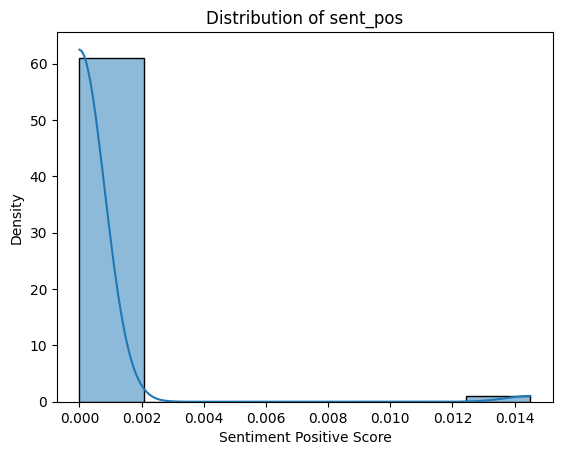

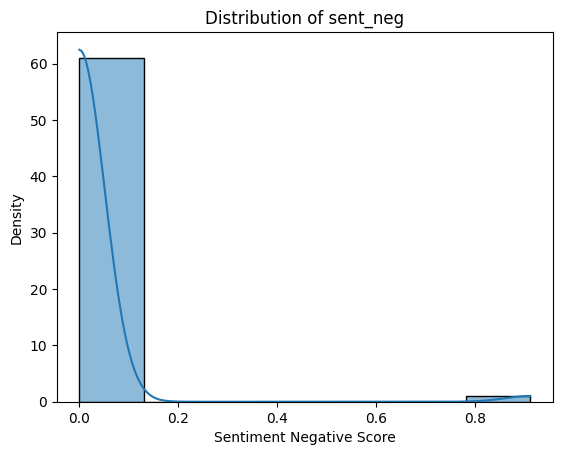

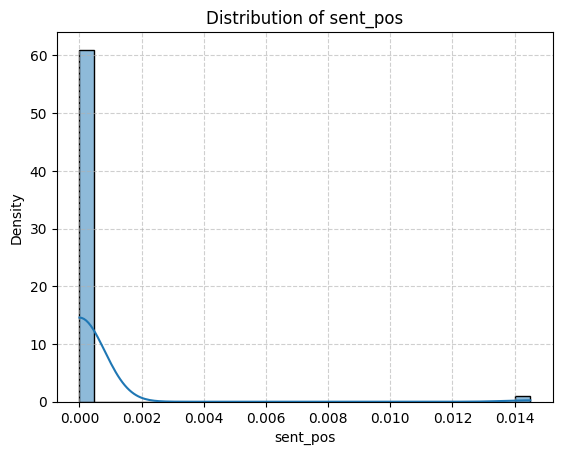

        sent_pos   sent_neg  sent_neutral
count  62.000000  62.000000     62.000000
mean    0.000234   0.014708      0.001187
std     0.001842   0.115809      0.009349
min     0.000000   0.000000      0.000000
25%     0.000000   0.000000      0.000000
50%     0.000000   0.000000      0.000000
75%     0.000000   0.000000      0.000000
max     0.014508   0.911879      0.073614


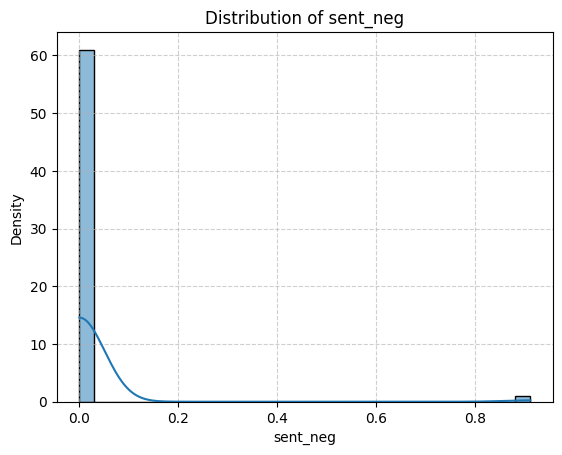

        sent_pos   sent_neg  sent_neutral
count  62.000000  62.000000     62.000000
mean    0.000234   0.014708      0.001187
std     0.001842   0.115809      0.009349
min     0.000000   0.000000      0.000000
25%     0.000000   0.000000      0.000000
50%     0.000000   0.000000      0.000000
75%     0.000000   0.000000      0.000000
max     0.014508   0.911879      0.073614


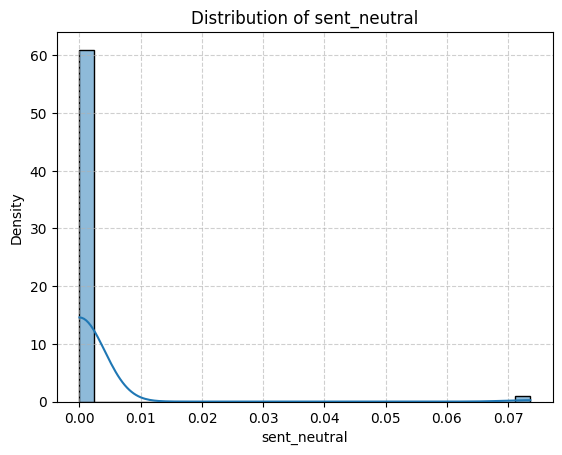

        sent_pos   sent_neg  sent_neutral
count  62.000000  62.000000     62.000000
mean    0.000234   0.014708      0.001187
std     0.001842   0.115809      0.009349
min     0.000000   0.000000      0.000000
25%     0.000000   0.000000      0.000000
50%     0.000000   0.000000      0.000000
75%     0.000000   0.000000      0.000000
max     0.014508   0.911879      0.073614


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Recompute data
price_data = get_price_data(days=60)
sentiment_data = load_sentiment_data()
features = create_features(price_data, sentiment_data)

# Extract the same features used in training
feature_cols = ['RSI_14', 'MACD', 'Volume_Spike', 'sent_pos', 'sent_neg']
X = features[feature_cols]

# Plot the distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(X['sent_pos'], kde=True)
plt.title("Distribution of sent_pos")
plt.xlabel("Sentiment Positive Score")
plt.ylabel("Density")
plt.show()

sns.histplot(X['sent_neg'], kde=True)
plt.title("Distribution of sent_neg")  
plt.xlabel("Sentiment Negative Score")  
plt.ylabel("Density")
plt.show()

sentiment_cols = ['sent_pos', 'sent_neg', 'sent_neutral']
for col in sentiment_cols:
    sns.histplot(features[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(features[['sent_pos', 'sent_neg', 'sent_neutral']].describe())
